## 尝试分层剔除测井曲线的一些异常值


In [1]:
import os
import sys
from pathlib import Path
from typing import Dict, Optional, Tuple

import lasio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 添加src目录到路径
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from utils.well_log_outlier_detector import (
    ANOMALY_RULES,
    apply_statistical_filter_3sigma,
    apply_statistical_filter_iqr,
    detect_anomalies,
)

# 设置中文字体支持
plt.rcParams["font.sans-serif"] = ["SimHei", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False

In [2]:
# ============ 配置参数 ============

# 定义路径
LAS_FOLDER = "../data/vertical_well_truncated_las"
HORIZON_FILE = "../data/well_horizon_processed.xlsx"
OUTPUT_FOLDER = "../data/vertical_well_las_delete_outliers_by_layers"

# 创建输出文件夹
output_path = Path(OUTPUT_FOLDER)
output_path.mkdir(parents=True, exist_ok=True)

# 定义砂组层序（从上到下）
SAND_GROUPS = [
    "H1-1",
    "H2-1",
    "H3-1",
    "H4-1",
    "H5-1",
    "H6-1",
    "H7-1",
    "H8-1",
    "P0",
]

# 异常值检测配置
DETECTION_CONFIG = {
    "use_3sigma": True,  # 是否使用3σ法则
    "use_iqr": True,  # 是否使用IQR方法
    "sigma": 3.0,  # 3σ法则的标准差倍数
    "iqr_multiplier": 1.5,  # IQR方法的倍数(1.5为温和离群点,3.0为极端离群点)
    "combine_method": "intersection",  # 统计方法组合方式: "union"(并集)或"intersection"(交集)
    "min_samples": 100,  # 层段最小样本量阈值
}

print("=" * 80)
print("分层处理测井曲线异常值")
print("=" * 80)
print("\n异常值规则:")
for curve, rule in ANOMALY_RULES.items():
    min_str = f"{rule['min']}" if rule["min"] is not None else "无限制"
    max_str = f"{rule['max']}" if rule["max"] is not None else "无限制"
    print(f"  {curve:8s}: [{min_str:8s}, {max_str:8s}] - {rule['description']}")

print("\n统计方法配置:")
print(f"  3σ法则: {'启用' if DETECTION_CONFIG['use_3sigma'] else '禁用'} (σ={DETECTION_CONFIG['sigma']})")
print(f"  IQR方法: {'启用' if DETECTION_CONFIG['use_iqr'] else '禁用'} (倍数={DETECTION_CONFIG['iqr_multiplier']})")
print(f"  组合方式: {DETECTION_CONFIG['combine_method']}")
print(f"  最小样本量: {DETECTION_CONFIG['min_samples']}")
print(f"\n层位顺序: {' → '.join(SAND_GROUPS)}")

分层处理测井曲线异常值

异常值规则:
  GR      : [0       , 无限制     ] - GR不能为负值(物理意义)
  DEN     : [1.0     , 3.0     ] - 密度小于1.0表示井眼扩径或钻井液,大于3.0不合理
  RHOB    : [1.0     , 3.0     ] - 密度小于1.0表示井眼扩径或钻井液,大于3.0不合理
  DT      : [40      , 200     ] - 小于40为跳周现象,大于200表示极疏松地层或异常
  AC      : [40      , 200     ] - 小于40为跳周现象,大于200表示极疏松地层或异常
  CAL     : [8.5     , 16.0    ] - 井径不应小于钻头尺寸,远大于钻头尺寸表示严重扩径
  CALI    : [8.5     , 16.0    ] - 井径不应小于钻头尺寸,远大于钻头尺寸表示严重扩径
  LLD     : [0.1     , 2000    ] - 极低值表示仪器短路,极高值需要截断
  LLD1    : [0.1     , 2000    ] - 极低值表示仪器短路,极高值需要截断
  POR     : [0.1     , 1.0     ] - 0.1的孔隙度是一个默认值，可以去除小于等于该值的数据

统计方法配置:
  3σ法则: 启用 (σ=3.0)
  IQR方法: 启用 (倍数=1.5)
  组合方式: intersection
  最小样本量: 100

层位顺序: H1-1 → H2-1 → H3-1 → H4-1 → H5-1 → H6-1 → H7-1 → H8-1 → P0


In [3]:
# ============ 分层异常值检测函数 ============


def detect_outliers_by_geological_layers(
    data: np.ndarray,
    depth: np.ndarray,
    horizon_df: pd.DataFrame,
    well_name: str,
    sand_groups: list,
    rule: Optional[Dict] = None,
    use_3sigma: bool = True,
    use_iqr: bool = True,
    sigma: float = 3.0,
    iqr_multiplier: float = 1.5,
    combine_method: str = "union",
    min_samples: int = 100,
    verbose: bool = True,
) -> Tuple[np.ndarray, Dict]:
    """
    按地质层段分层检测异常值

    工作流程:
    1. 先用先验规则进行全局检测
    2. 根据层位数据将井段划分为多个层段
    3. 在每个层段内独立进行统计学异常值检测
    4. 合并所有异常值

    层段划分规则:
    - 每个层位的深度作为该层段的顶界,延伸到下一层位
    - 最顶层位以上和最底层位以下的数据不参与处理
    - 每个层位上的数据点归属于其下方的层段

    Parameters:
    -----------
    data : np.ndarray
        测井数据
    depth : np.ndarray
        深度数据
    horizon_df : pd.DataFrame
        层位数据表,必须包含列: ['Well', 'Surface', 'MD']
    well_name : str
        井名
    sand_groups : list
        砂组层序列表(从上到下)
    rule : dict, optional
        先验规则,格式: {"min": float, "max": float, "description": str}
    use_3sigma : bool
        是否使用3σ法则
    use_iqr : bool
        是否使用IQR方法
    sigma : float
        3σ法则的标准差倍数
    iqr_multiplier : float
        IQR方法的倍数
    combine_method : str
        统计方法组合方式: "union"或"intersection"
    min_samples : int
        层段最小样本量阈值
    verbose : bool
        是否打印详细信息

    Returns:
    --------
    total_mask : np.ndarray
        总异常值掩码(True表示异常)
    stats : dict
        详细统计信息
    """
    # 初始化
    original_count = len(data)
    total_mask = np.zeros(len(data), dtype=bool)

    stats = {
        "original_count": original_count,
        "prior_count": 0,
        "prior_pct": 0.0,
        "statistical_count": 0,
        "statistical_pct": 0.0,
        "total_count": 0,
        "total_pct": 0.0,
        "valid_count": 0,
        "layers_processed": 0,
        "layers_skipped": 0,
        "layer_details": [],
    }

    # ========== 1. 先验规则检测(全局) ==========
    if rule is not None:
        prior_mask = detect_anomalies(data, min_val=rule.get("min"), max_val=rule.get("max"))
        prior_count = np.sum(prior_mask)
        stats["prior_count"] = prior_count
        stats["prior_pct"] = (prior_count / original_count) * 100 if original_count > 0 else 0
        total_mask |= prior_mask

        if verbose:
            print(f"  先验异常值(全局): {prior_count} ({stats['prior_pct']:.2f}%)")

    # ========== 2. 获取该井的层位数据 ==========
    well_horizons = horizon_df[horizon_df["Well"] == well_name].copy()

    if len(well_horizons) == 0:
        if verbose:
            print(f"  ⚠️ 未找到井 {well_name} 的层位数据,跳过分层处理")
        stats["statistical_count"] = 0
        stats["statistical_pct"] = 0.0
        stats["total_count"] = stats["prior_count"]
        stats["total_pct"] = stats["prior_pct"]
        stats["valid_count"] = original_count - stats["total_count"]
        return total_mask, stats

    # 筛选出存在的砂组层位并按深度排序
    well_sand_groups = well_horizons[well_horizons["Surface"].isin(sand_groups)].copy()
    well_sand_groups = well_sand_groups.sort_values("MD").reset_index(drop=True)

    if len(well_sand_groups) < 2:
        if verbose:
            print(f"  ⚠️ 井 {well_name} 的层位数少于2个,无法分层处理")
        stats["statistical_count"] = 0
        stats["statistical_pct"] = 0.0
        stats["total_count"] = stats["prior_count"]
        stats["total_pct"] = stats["prior_pct"]
        stats["valid_count"] = original_count - stats["total_count"]
        return total_mask, stats

    if verbose:
        print(f"  找到 {len(well_sand_groups)} 个层位")
        print(
            f"  深度范围: {well_sand_groups['Surface'].iloc[0]} ({well_sand_groups['MD'].iloc[0]:.2f}m) "
            f"→ {well_sand_groups['Surface'].iloc[-1]} ({well_sand_groups['MD'].iloc[-1]:.2f}m)"
        )

    # ========== 3. 按层段处理 ==========
    statistical_mask = np.zeros(len(data), dtype=bool)

    # 遍历每个层段(从第一个层位到倒数第二个层位)
    for i in range(len(well_sand_groups) - 1):
        top_surface = well_sand_groups.iloc[i]["Surface"]
        bottom_surface = well_sand_groups.iloc[i + 1]["Surface"]
        top_md = well_sand_groups.iloc[i]["MD"]
        bottom_md = well_sand_groups.iloc[i + 1]["MD"]

        # 获取该层段的数据掩码
        # 注意: 包含顶界点,不包含底界点(底界点属于下一层段)
        layer_mask = (depth >= top_md) & (depth < bottom_md)
        layer_count = np.sum(layer_mask)

        layer_info = {
            "layer": f"{top_surface} → {bottom_surface}",
            "top_surface": top_surface,
            "bottom_surface": bottom_surface,
            "top_md": top_md,
            "bottom_md": bottom_md,
            "thickness": bottom_md - top_md,
            "total_points": layer_count,
            "processed": False,
            "skip_reason": None,
            "prior_outliers": 0,
            "statistical_outliers": 0,
        }

        if verbose:
            print(f"\n  --- 层段 {i + 1}/{len(well_sand_groups) - 1}: {top_surface} → {bottom_surface} ---")
            print(f"      深度: {top_md:.2f}m - {bottom_md:.2f}m (厚度: {bottom_md - top_md:.2f}m)")
            print(f"      数据点数: {layer_count}")

        # 检查样本量
        if layer_count < min_samples:
            if verbose:
                print(f"      ⚠️ 样本量不足({layer_count} < {min_samples}),跳过该层段")
            layer_info["skip_reason"] = f"样本量不足({layer_count} < {min_samples})"
            stats["layers_skipped"] += 1
            stats["layer_details"].append(layer_info)
            continue

        # 提取该层段数据
        layer_data = data[layer_mask]

        # 统计该层段中的先验异常值
        layer_prior_mask = total_mask[layer_mask]
        layer_prior_count = np.sum(layer_prior_mask)
        layer_info["prior_outliers"] = layer_prior_count

        # 计算去除先验异常值后的有效样本量
        valid_layer_mask = ~layer_prior_mask
        valid_layer_count = np.sum(valid_layer_mask)

        if verbose and layer_prior_count > 0:
            print(f"      先验异常值: {layer_prior_count} ({(layer_prior_count / layer_count) * 100:.2f}%)")
            print(f"      有效样本: {valid_layer_count}")

        if valid_layer_count < min_samples:
            if verbose:
                print(f"      ⚠️ 去除先验异常值后样本量不足({valid_layer_count} < {min_samples}),跳过")
            layer_info["skip_reason"] = f"有效样本不足({valid_layer_count} < {min_samples})"
            stats["layers_skipped"] += 1
            stats["layer_details"].append(layer_info)
            continue

        # ========== 在该层段内进行统计检测 ==========
        layer_statistical_mask = np.zeros(layer_count, dtype=bool)

        # 根据配置选择统计方法
        if use_3sigma and use_iqr:
            # 同时使用两种方法
            sigma_mask = apply_statistical_filter_3sigma(layer_data, sigma=sigma, verbose=verbose)
            iqr_mask = apply_statistical_filter_iqr(layer_data, multiplier=iqr_multiplier, verbose=verbose)

            if combine_method == "union":
                layer_statistical_mask = sigma_mask | iqr_mask
            else:  # intersection
                layer_statistical_mask = sigma_mask & iqr_mask

        elif use_3sigma:
            layer_statistical_mask = apply_statistical_filter_3sigma(layer_data, sigma=sigma, verbose=verbose)

        elif use_iqr:
            layer_statistical_mask = apply_statistical_filter_iqr(
                layer_data, multiplier=iqr_multiplier, verbose=verbose
            )

        # 只标记非先验异常的统计离群值
        layer_statistical_only = layer_statistical_mask & valid_layer_mask
        statistical_count_in_layer = np.sum(layer_statistical_only)

        layer_info["statistical_outliers"] = statistical_count_in_layer
        layer_info["processed"] = True

        if verbose:
            print(
                f"      统计离群值: {statistical_count_in_layer} ({(statistical_count_in_layer / layer_count) * 100:.2f}%)"
            )

        # 更新全局掩码
        global_indices = np.where(layer_mask)[0]
        statistical_mask[global_indices[layer_statistical_only]] = True

        stats["layers_processed"] += 1
        stats["layer_details"].append(layer_info)

    # ========== 4. 合并所有异常值 ==========
    total_mask |= statistical_mask

    stats["statistical_count"] = np.sum(statistical_mask)
    stats["statistical_pct"] = (stats["statistical_count"] / original_count) * 100 if original_count > 0 else 0
    stats["total_count"] = np.sum(total_mask)
    stats["total_pct"] = (stats["total_count"] / original_count) * 100 if original_count > 0 else 0
    stats["valid_count"] = original_count - stats["total_count"]

    if verbose:
        print(f"\n  === 汇总 ===")
        print(f"  处理层段数: {stats['layers_processed']}")
        print(f"  跳过层段数: {stats['layers_skipped']}")
        print(f"  统计离群值(分层): {stats['statistical_count']} ({stats['statistical_pct']:.2f}%)")
        print(f"  总异常值: {stats['total_count']} ({stats['total_pct']:.2f}%)")
        print(f"  有效数据点数: {stats['valid_count']}")

    return total_mask, stats

In [ ]:
# ============ 读取层位数据 ============

print("\n" + "=" * 80)
print("读取层位数据...")
print("=" * 80)

horizon_df = pd.read_excel(HORIZON_FILE)
# print(f"层位数据: {len(horizon_df)} 条记录")
# print(f"包含的井: {sorted(horizon_df['Well'].unique())}")

# # 统计每口井的层位数
# well_horizon_counts = horizon_df.groupby("Well").size()
# print(f"\n各井层位数量:")
# for well, count in well_horizon_counts.items():
#     print(f"  {well}: {count}")


读取层位数据...
层位数据: 1045 条记录
包含的井: ['A1', 'A10', 'A10s', 'A11', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'AA5', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'BA6', 'BA6S', 'BG2', 'BG3', 'PH1', 'PH11', 'PH13', 'PH18', 'PH19', 'PH2', 'PH3', 'PH4', 'PH5', 'PH6', 'PH7', 'PH8', 'SHX36-5-A4']

各井层位数量:
  A1: 27
  A10: 25
  A10s: 6
  A11: 33
  A2: 27
  A3: 7
  A4: 33
  A5: 26
  A6: 33
  A7: 6
  A8: 24
  A9: 33
  AA5: 24
  B1: 33
  B2: 33
  B3: 33
  B4: 33
  B5: 33
  B6: 33
  B7: 33
  B8: 33
  B9: 33
  BA6: 33
  BA6S: 33
  BG2: 7
  BG3: 8
  PH1: 33
  PH11: 8
  PH13: 26
  PH18: 24
  PH19: 33
  PH2: 33
  PH3: 33
  PH4: 33
  PH5: 33
  PH6: 33
  PH7: 33
  PH8: 33
  SHX36-5-A4: 8



开始处理LAS文件...

找到 6 个LAS文件

处理井: PH1
深度曲线: DEPT
深度范围: 2092.30m - 3027.50m

曲线: CAL
  原始数据点数: 9353
  先验异常值(全局): 0 (0.00%)
  找到 9 个层位
  深度范围: H1-1 (2142.29m) → P0 (2977.58m)

  --- 层段 1/8: H1-1 → H2-1 ---
      深度: 2142.29m - 2289.50m (厚度: 147.21m)
      数据点数: 1472
  [3σ法则] 均值: 13.27, 标准差: 0.48
  [IQR方法] Q1: 12.87, Q3: 13.68, IQR: 0.81
  [IQR方法] 边界: [11.65, 14.90]
      统计离群值: 0 (0.00%)

  --- 层段 2/8: H2-1 → H3-1 ---
      深度: 2289.50m - 2375.57m (厚度: 86.07m)
      数据点数: 861
  [3σ法则] 均值: 12.86, 标准差: 0.52
  [IQR方法] Q1: 12.49, Q3: 13.26, IQR: 0.77
  [IQR方法] 边界: [11.32, 14.42]
      统计离群值: 0 (0.00%)

  --- 层段 3/8: H3-1 → H4-1 ---
      深度: 2375.57m - 2460.16m (厚度: 84.59m)
      数据点数: 846
  [3σ法则] 均值: 12.65, 标准差: 0.28
  [IQR方法] Q1: 12.50, Q3: 12.64, IQR: 0.14
  [IQR方法] 边界: [12.28, 12.85]
      统计离群值: 14 (1.65%)

  --- 层段 4/8: H4-1 → H5-1 ---
      深度: 2460.16m - 2570.10m (厚度: 109.94m)
      数据点数: 1099
  [3σ法则] 均值: 12.72, 标准差: 0.34
  [IQR方法] Q1: 12.44, Q3: 12.99, IQR: 0.55
  [IQR方法] 边界: [11.6

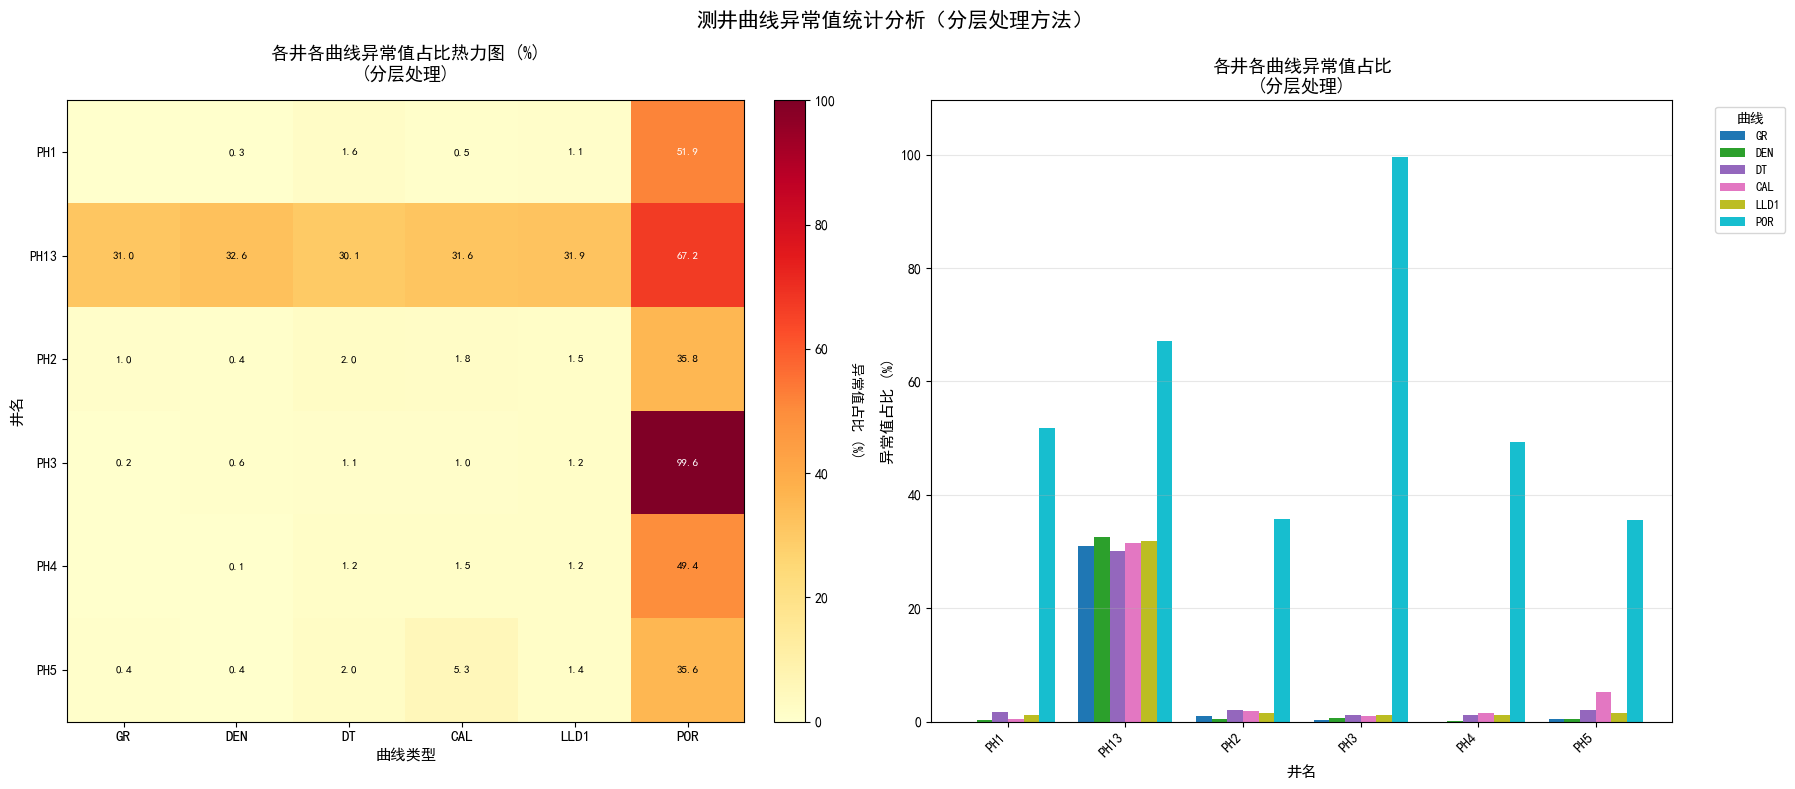


✓ 所有处理完成!


In [5]:
# ============ 处理LAS文件 ============

print("\n" + "=" * 80)
print("开始处理LAS文件...")
print("=" * 80)

# 获取所有LAS文件
input_path = Path(LAS_FOLDER)
las_files = list(input_path.glob("*.las"))
las_files = list(set(las_files))  # 去重
las_files.sort()

if not las_files:
    print(f"\n在 {LAS_FOLDER} 中未找到LAS文件")
else:
    print(f"\n找到 {len(las_files)} 个LAS文件")

    # 统计信息
    processing_stats = []
    success_count = 0
    failed_files = []

    for las_file in las_files:
        well_name = las_file.stem
        print(f"\n{'=' * 80}")
        print(f"处理井: {well_name}")
        print(f"{'=' * 80}")

        try:
            # 读取LAS文件
            las = lasio.read(las_file, mnemonic_case="upper")

            # 获取深度数据
            depth_curve = None
            for mnemonic in ["DEPT", "DEPTH", "MD"]:
                if mnemonic in [c.mnemonic for c in las.curves]:
                    depth_curve = mnemonic
                    break

            if depth_curve is None:
                print(f"  ✗ 未找到深度曲线,跳过")
                failed_files.append((well_name, "无深度曲线"))
                continue

            depth_data = las[depth_curve]
            print(f"深度曲线: {depth_curve}")
            print(f"深度范围: {depth_data.min():.2f}m - {depth_data.max():.2f}m")

            # 统计该井的异常值信息
            well_stats = {
                "Well": well_name,
                "Depth_Min": depth_data.min(),
                "Depth_Max": depth_data.max(),
                "Depth_Range": depth_data.max() - depth_data.min(),
                "Total_Points": len(depth_data),
            }

            # 创建新的LAS对象
            new_las = lasio.LASFile()
            new_las.version = las.version
            new_las.well = las.well
            new_las.params = las.params
            new_las.other = las.other

            # 处理每条曲线
            for curve in las.curves:
                mnemonic = curve.mnemonic
                data = curve.data.copy()
                original_count = len(data)

                # 检查是否有对应的异常值规则
                rule = ANOMALY_RULES.get(mnemonic)

                if rule is not None:
                    print(f"\n曲线: {mnemonic}")
                    print(f"  原始数据点数: {original_count}")

                    # 使用分层检测方法
                    total_mask, stats = detect_outliers_by_geological_layers(
                        data=data,
                        depth=depth_data,
                        horizon_df=horizon_df,
                        well_name=well_name,
                        sand_groups=SAND_GROUPS,
                        rule=rule,
                        **DETECTION_CONFIG,
                        verbose=True,
                    )

                    # 将异常值设为NaN
                    data[total_mask] = np.nan

                    # 记录统计信息
                    well_stats[f"{mnemonic}_Points"] = stats["original_count"]
                    well_stats[f"{mnemonic}_Prior_Count"] = stats["prior_count"]
                    well_stats[f"{mnemonic}_Prior_Pct"] = stats["prior_pct"]
                    well_stats[f"{mnemonic}_Statistical_Count"] = stats["statistical_count"]
                    well_stats[f"{mnemonic}_Statistical_Pct"] = stats["statistical_pct"]
                    well_stats[f"{mnemonic}_Total_Count"] = stats["total_count"]
                    well_stats[f"{mnemonic}_Total_Pct"] = stats["total_pct"]
                    well_stats[f"{mnemonic}_Valid_Count"] = stats["valid_count"]
                    well_stats[f"{mnemonic}_Layers_Processed"] = stats["layers_processed"]
                    well_stats[f"{mnemonic}_Layers_Skipped"] = stats["layers_skipped"]

                else:
                    # 对于没有先验规则的曲线,只进行基本的NaN和Inf检测
                    basic_mask = np.isnan(data) | np.isinf(data)
                    basic_anomaly_count = np.sum(basic_mask)

                    if basic_anomaly_count > 0:
                        print(f"\n曲线: {mnemonic}")
                        print(f"  原始数据点数: {original_count}")
                        print(f"  NaN/Inf异常: {basic_anomaly_count}")
                        data[basic_mask] = np.nan

                # 添加处理后的曲线
                new_las.append_curve(
                    mnemonic=curve.mnemonic,
                    data=data,
                    unit=curve.unit,
                    descr=curve.descr,
                    value=curve.value,
                )

            # 保存处理后的文件
            output_file = output_path / las_file.name
            new_las.write(str(output_file), version=2.0)

            print(f"\n✓ 成功处理并保存到 {output_file.name}")
            success_count += 1

            # 保存统计信息
            processing_stats.append(well_stats)

        except Exception as e:
            print(f"\n✗ 处理失败: {e}")
            import traceback

            traceback.print_exc()
            failed_files.append((well_name, str(e)))

    # ============ 保存处理统计信息 ============

    if processing_stats:
        stats_df = pd.DataFrame(processing_stats)
        stats_file = "output/processing_statistics_by_layers.xlsx"
        stats_df.to_excel(stats_file, index=False)
        print(f"\n统计信息已保存到: {stats_file}")

    # ============ 输出总体统计 ============

    print("\n" + "=" * 80)
    print("处理完成!")
    print("=" * 80)
    print(f"成功: {success_count}/{len(las_files)}")

    if failed_files:
        print(f"\n失败的文件:")
        for filename, error in failed_files:
            print(f"  - {filename}: {error}")

    # ============ 可视化统计结果 ============

    if processing_stats:
        print("\n" + "=" * 80)
        print("生成统计图表...")
        print("=" * 80)

        stats_df = pd.DataFrame(processing_stats)

        # 统计各曲线的异常值情况
        curves_to_analyze = ["GR", "DEN", "RHOB", "DT", "AC", "CAL", "CALI", "LLD", "LLD1", "POR"]

        # 提取异常值百分比数据
        anomaly_pct_data = {}
        for curve in curves_to_analyze:
            pct_col = f"{curve}_Total_Pct"
            if pct_col in stats_df.columns:
                anomaly_pct_data[curve] = stats_df[pct_col].fillna(0).values

        # 创建对比图表
        if anomaly_pct_data:
            fig, axes = plt.subplots(1, 2, figsize=(18, 8))

            # 1. 热力图
            ax1 = axes[0]
            pct_df = pd.DataFrame(anomaly_pct_data, index=stats_df["Well"])
            pct_df_filtered = pct_df.loc[:, (pct_df > 0).any()]

            if len(pct_df_filtered.columns) > 0:
                im = ax1.imshow(pct_df_filtered.values, cmap="YlOrRd", aspect="auto", vmin=0, vmax=100)
                ax1.set_xticks(range(len(pct_df_filtered.columns)))
                ax1.set_xticklabels(pct_df_filtered.columns, fontsize=11, fontweight="bold")
                ax1.set_yticks(range(len(pct_df_filtered.index)))
                ax1.set_yticklabels(pct_df_filtered.index, fontsize=10)
                ax1.set_title("各井各曲线异常值占比热力图 (%)\n(分层处理)", fontweight="bold", fontsize=13, pad=15)
                ax1.set_xlabel("曲线类型", fontsize=11, fontweight="bold")
                ax1.set_ylabel("井名", fontsize=11, fontweight="bold")

                cbar = plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
                cbar.set_label("异常值占比 (%)", rotation=270, labelpad=20, fontsize=10)

                # 标注数值
                for i in range(len(pct_df_filtered.index)):
                    for j in range(len(pct_df_filtered.columns)):
                        value = pct_df_filtered.values[i, j]
                        if value > 0:
                            text_color = "white" if value > 50 else "black"
                            ax1.text(
                                j,
                                i,
                                f"{value:.1f}",
                                ha="center",
                                va="center",
                                color=text_color,
                                fontsize=8,
                                fontweight="bold",
                            )

            # 2. 柱状图 - 比较各井的异常值占比
            ax2 = axes[1]
            if len(pct_df_filtered.columns) > 0:
                pct_df_filtered.plot(kind="bar", ax=ax2, width=0.8, colormap="tab10")
                ax2.set_title("各井各曲线异常值占比\n(分层处理)", fontweight="bold", fontsize=13)
                ax2.set_xlabel("井名", fontsize=11)
                ax2.set_ylabel("异常值占比 (%)", fontsize=11)
                ax2.legend(title="曲线", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9)
                ax2.set_xticklabels(pct_df_filtered.index, rotation=45, ha="right", fontsize=10)
                ax2.grid(axis="y", alpha=0.3)
                ax2.set_ylim(0, max(100, pct_df_filtered.max().max() * 1.1))

            fig.suptitle("测井曲线异常值统计分析（分层处理方法）", fontsize=15, fontweight="bold", y=0.98)
            plt.tight_layout()

            # 保存图表
            fig_file = "output/anomaly_statistics_by_layers.png"
            plt.savefig(fig_file, dpi=300, bbox_inches="tight")
            print(f"统计图表已保存到: {fig_file}")

        # ============ 输出统计摘要 ============

        print("\n" + "=" * 80)
        print("异常值统计摘要（分层处理）")
        print("=" * 80)

        if anomaly_pct_data:
            pct_df = pd.DataFrame(anomaly_pct_data, index=stats_df["Well"])
            print("\n各曲线平均异常值占比:")
            for col in pct_df.columns:
                if pct_df[col].sum() > 0:
                    avg_pct = pct_df[col].mean()
                    max_pct = pct_df[col].max()
                    max_well = pct_df[col].idxmax()
                    print(f"  {col:8s}: 平均 {avg_pct:5.2f}%  最大 {max_pct:5.2f}% ({max_well})")

            print("\n异常值占比最高的5口井:")
            well_avg = pct_df.mean(axis=1).sort_values(ascending=False).head(5)
            for well, avg in well_avg.items():
                print(f"  {well:20s}: {avg:5.2f}%")

        plt.show()

print("\n" + "=" * 80)
print("✓ 所有处理完成!")
print("=" * 80)